In [6]:
import os
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable
from collections import deque, namedtuple

In [7]:
# Não esquecer este import muito importante, de preferência usar no terminal
# pip install Box2D

In [8]:
# ! pip install swig
# ! pip install gymnasium
# ! pip install gymnasium[box2d]

In [9]:
env = gym.make("LunarLander-v3", gravity=-10, continuous=False,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)



Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)


In [10]:
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n

In [11]:
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  (8,)
State size:  8
Number of actions:  4


In [12]:

def random_policy(env, state):
    return env.action_space.sample()

state = env.reset()[0]

for counter in range(201):

    env.render()

    #select the action according to the given policy
    action = random_policy(env, state)
    
    #perform the action and store the next state information
    next_state, reward, done, truncated, info = env.step(action)

    if counter % 10 == 0:
        print("Step:", counter, next_state, reward, done, info)
        
env.close()

Step: 0 [-0.00461969  1.4237826  -0.23364241  0.27298233  0.00530192  0.0523813
  0.          0.        ] 1.1323274726150032 False {}
Step: 10 [-0.02669239  1.4605452  -0.2204676   0.070843    0.03735081  0.03996315
  0.          0.        ] 0.5862066415189133 False {}
Step: 20 [-0.04719305  1.4670162  -0.18704195 -0.06474226  0.05049383 -0.02539295
  0.          0.        ] 0.4096387403801043 False {}
Step: 30 [-0.06822338  1.4412851  -0.19419596 -0.14799924  0.03883861 -0.06643749
  0.          0.        ] -0.01842257915160303 False {}
Step: 40 [-0.08653698  1.380375   -0.16379884 -0.3144379  -0.03830798 -0.2123827
  0.          0.        ] -0.018486918505533356 False {}
Step: 50 [-0.10237541  1.2826144  -0.12617269 -0.511019   -0.14260955 -0.2888937
  0.          0.        ] 1.152865494026355 False {}
Step: 60 [-0.11196146  1.1488566  -0.01558399 -0.6151424  -0.2915737  -0.30391067
  0.          0.        ] 3.0976184903506807 False {}
Step: 70 [-0.1085639   1.0205933   0.09296797 -0

c:\Users\ruben\.conda\envs\DM2425\Lib\site-packages\gymnasium\envs\box2d\lunar_lander.py:672: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("LunarLander-v3", render_mode="rgb_array")
  gym.logger.warn(


In [13]:
seed_value = 42

env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
env.reset(seed=seed_value)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_low = float(env.action_space.low[0])
action_high = float(env.action_space.high[0])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.out(x))  # Output in [-1, 1]

In [15]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [16]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(tuple(map(np.array, args)))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        return map(lambda x: torch.FloatTensor(np.vstack(x)).to(device), zip(*samples))

    def __len__(self):
        return len(self.buffer)

In [17]:
class DDPG:
    def __init__(self):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_target = Actor(state_dim, action_dim).to(device)
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-2)
        self.memory = ReplayBuffer()
        self.gamma = 0.99
        self.tau = 0.005

    def select_action(self, state, noise=0.1):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.actor(state).detach().cpu().numpy()[0]
        action = action + noise * np.random.randn(action_dim)
        return np.clip(action, action_low, action_high)

    def train(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)

        # Critic loss
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_Q = self.critic_target(next_states, next_actions)
            target_Q = rewards + self.gamma * (1 - dones) * target_Q
        current_Q = self.critic(states, actions)
        critic_loss = F.mse_loss(current_Q, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [18]:
agent = DDPG()
episodes = 1000
timesteps = 300
initial_noise = 0.5
final_noise = 0.025
noise_decay = 0.995


In [19]:
for ep in range(episodes):
    state = env.reset()[0]
    episode_reward = 0
    noise = max(final_noise, initial_noise * (noise_decay ** ep))
    for t in range(timesteps):
        action = agent.select_action(state, noise=noise)
        next_state, reward, done, _, _ = env.step(action)
        agent.memory.push(state, action, reward, next_state, float(done))
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    print(f"Episode {ep+1}, Reward: {episode_reward:.2f}, Noise: {noise:.3f}")

env.close()

Episode 1, Reward: -217.92, Noise: 0.500
Episode 2, Reward: -424.59, Noise: 0.497
Episode 3, Reward: -408.84, Noise: 0.495
Episode 4, Reward: -771.99, Noise: 0.493
Episode 5, Reward: -154.52, Noise: 0.490
Episode 6, Reward: -135.52, Noise: 0.488
Episode 7, Reward: -117.95, Noise: 0.485
Episode 8, Reward: -156.43, Noise: 0.483
Episode 9, Reward: -151.98, Noise: 0.480
Episode 10, Reward: -143.86, Noise: 0.478
Episode 11, Reward: -117.82, Noise: 0.476
Episode 12, Reward: -27.83, Noise: 0.473
Episode 13, Reward: 93.85, Noise: 0.471
Episode 14, Reward: -3.43, Noise: 0.468
Episode 15, Reward: -62.25, Noise: 0.466
Episode 16, Reward: -33.67, Noise: 0.464
Episode 17, Reward: -19.64, Noise: 0.461
Episode 18, Reward: -45.41, Noise: 0.459
Episode 19, Reward: -115.75, Noise: 0.457
Episode 20, Reward: -23.65, Noise: 0.455
Episode 21, Reward: -8.60, Noise: 0.452
Episode 22, Reward: -37.02, Noise: 0.450
Episode 23, Reward: -12.67, Noise: 0.448
Episode 24, Reward: -81.03, Noise: 0.446
Episode 25, Rewa

In [20]:
env.close()

In [21]:
render_env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
                      enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode='human')
render_env.reset(seed=seed_value)

(array([ 0.00229702,  1.4181306 ,  0.2326471 ,  0.3204666 , -0.00265488,
        -0.05269805,  0.        ,  0.        ], dtype=float32),
 {})

In [22]:
def test_agent(agent, env, episodes=5, max_steps=300):
    for ep in range(episodes):
        state = env.reset()[0]
        done = False
        episode_reward = 0
        step_count = 0
        while not done and step_count < max_steps:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action = agent.actor(state_tensor).cpu().numpy()[0]
            state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            step_count += 1
        print(f"Test Episode {ep+1}, Reward: {episode_reward:.2f}")
    render_env.close()


test_agent(agent, render_env)

Test Episode 1, Reward: -11.10
Test Episode 2, Reward: 174.59
Test Episode 3, Reward: 138.25
Test Episode 4, Reward: 139.60
Test Episode 5, Reward: 100.47


In [23]:
render_env.close()

# PPO

In [24]:
from stable_baselines3 import PPO
import gymnasium as gym

In [45]:
# Test/Evaluate PPO agent using your env (with render if you want)
env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=True, wind_power=15.0, turbulence_power=1.5
    )
env.reset(seed=seed_value)

env.close()

In [ ]:
# Create PPO model using your existing env
ppo_model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_lunar_tensorboard/")

# Train PPO
ppo_model.learn(total_timesteps=5_000_000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_lunar_tensorboard/PPO_10


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | -359     |
| time/              |          |
|    fps             | 3109     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 103        |
|    ep_rew_mean          | -352       |
| time/                   |            |
|    fps                  | 2149       |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00446542 |
|    clip_fraction        | 0.0354     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.84      |
|    explained_variance   | -0.0004    |
|    learning_rate        | 0.0003     |
|   

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Number of evaluation episodes
eval_episodes = 1000
episode_returns = []

for ep in range(eval_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done and steps < 300:  # limit steps if you want, to match training
        action, _ = ppo_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        steps += 1
        done = done or truncated
    episode_returns.append(total_reward)

avg_return = np.mean(episode_returns)
print(f"Average return over {eval_episodes} eval episodes: {avg_return:.2f}")


Average return over 1000 eval episodes: 157.16


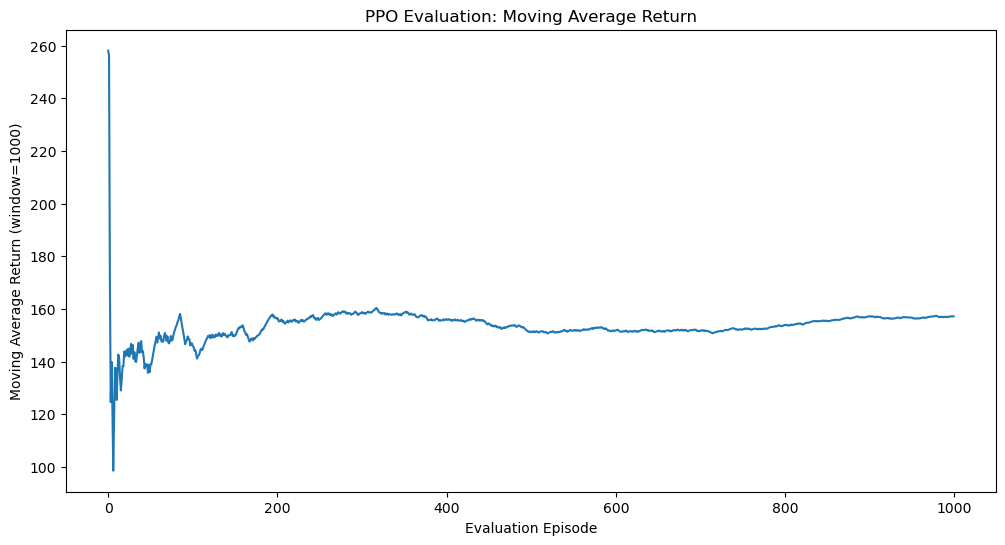

In [48]:
window = 1000
moving_avg = [np.mean(episode_returns[max(0, i - window):i + 1]) for i in range(len(episode_returns))]

plt.figure(figsize=(12, 6))
plt.plot(moving_avg)
plt.xlabel("Evaluation Episode")
plt.ylabel(f"Moving Average Return (window={window})")
plt.title("PPO Evaluation: Moving Average Return")
plt.show()


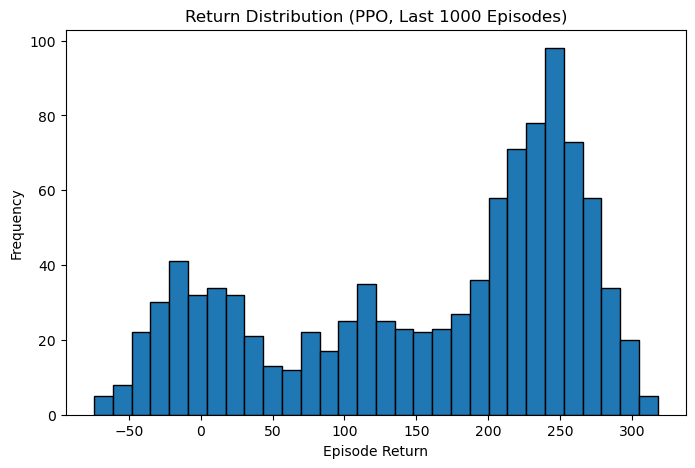

In [49]:
plt.figure(figsize=(8, 5))
plt.hist(episode_returns, bins=30, edgecolor='k')
plt.xlabel("Episode Return")
plt.ylabel("Frequency")
plt.title("Return Distribution (PPO, Last 1000 Episodes)")
plt.show()


In [62]:
test_env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=True, wind_power=15.0, turbulence_power=1.5)
test_env.reset(seed=seed_value)
test_env.close()

In [ ]:
from stable_baselines3 import PPO

# policy_kwargs = dict(
#     net_arch=[dict(pi=[256, 256], vf=[256, 256])]  # Deeper neural network for better function approximation
# )

# ppo_model = PPO(
#     "MlpPolicy",
#     test_env,                    # (Use a dedicated training env in practice)
#     n_steps=4096,                # Larger rollout for better GAE estimation
#     batch_size=256,              # Larger minibatch; try 128-256 for stability
#     gae_lambda=0.97,             # Slightly lower for less bias, more variance (helps in some envs)
#     gamma=0.99,                  # Discount factor
#     ent_coef=0.005,              # Slightly less entropy bonus late in training
#     learning_rate=1e-4,          # Slightly lower LR for more stable convergence
#     n_epochs=20,                 # More epochs for better minibatch fitting
#     clip_range=0.2,              # PPO default
#     verbose=1,
#     tensorboard_log="./ppo_lunar_tensorboard/",
#     policy_kwargs=policy_kwargs
# )

ppo_model = PPO(
    policy="MlpPolicy",
    env=env,
    n_steps=1024,        # Number of steps to run for each environment per update
    batch_size=64,       # Minibatch size
    gae_lambda=0.98,     # GAE lambda
    gamma=0.999,         # Discount factor
    ent_coef=0.01,       # Entropy coefficient
    n_epochs=4,          # Number of epochs per update
    verbose=1,
    tensorboard_log="./ppo_lunar_tensorboard/"
    # No obs normalization; stable_baselines3 does not normalize by default
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
# Train PPO
ppo_model.learn(total_timesteps=5_000_000)

Logging to ./ppo_lunar_tensorboard/PPO_13
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -356     |
| time/              |          |
|    fps             | 2864     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | -354         |
| time/                   |              |
|    fps                  | 2502         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0011265432 |
|    clip_fraction        | 0.00146      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_v

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Number of evaluation episodes
eval_episodes = 1000
episode_returns = []

for ep in range(eval_episodes):
    obs, _ = test_env.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done and steps < 300:  # limit steps if you want, to match training
        action, _ = ppo_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = test_env.step(action)
        total_reward += reward
        steps += 1
        done = done or truncated
    episode_returns.append(total_reward)

avg_return = np.mean(episode_returns)
print(f"Average return over {eval_episodes} eval episodes: {avg_return:.2f}")


Average return over 1000 eval episodes: 180.92


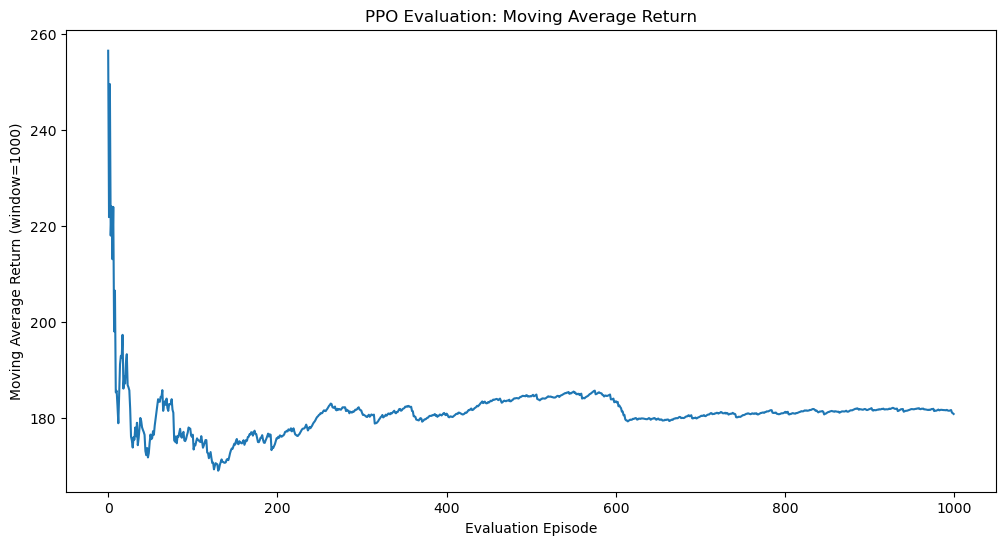

In [66]:
window = 1000
moving_avg = [np.mean(episode_returns[max(0, i - window):i + 1]) for i in range(len(episode_returns))]

plt.figure(figsize=(12, 6))
plt.plot(moving_avg)
plt.xlabel("Evaluation Episode")
plt.ylabel(f"Moving Average Return (window={window})")
plt.title("PPO Evaluation: Moving Average Return")
plt.show()


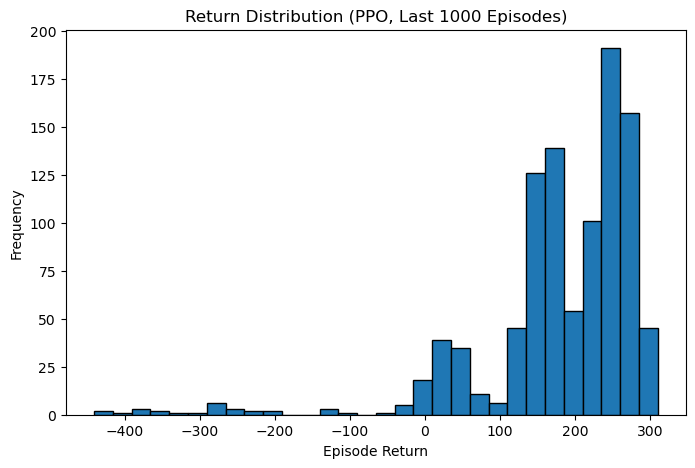

In [67]:
plt.figure(figsize=(8, 5))
plt.hist(episode_returns, bins=30, edgecolor='k')
plt.xlabel("Episode Return")
plt.ylabel("Frequency")
plt.title("Return Distribution (PPO, Last 1000 Episodes)")
plt.show()
